An example of how to fit the WCS of an all-sky camera

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from lsst.all_sky_phot.wcs import AZP_affine, AZP_SIP, ZEA_affine
from read_stars import read_manual_stars
from scipy.optimize import minimize

In [2]:
# Read in stars measured off several exposures
stars = read_manual_stars('starcoords.dat')
stars

If you need enough precision such that this matters (~<10 arcsec), you can
use the latest IERS predictions by running:

    >>> from astropy.utils import iers
    >>> iers.IERS.iers_table = iers.IERS_A.open(iers.IERS_A_URL)

 [astropy.coordinates.builtin_frames.utils]
If you need enough precision such that this matters (~<10 arcsec), you can
use the latest IERS predictions by running:

    >>> from astropy.utils import iers
    >>> iers.IERS.iers_table = iers.IERS_A.open(iers.IERS_A_URL)

 [astropy.coordinates.builtin_frames.utils]


array([ ('Achernar', 3441.0, 2918.0, 57415.03236111111, 49.947050461141515, 215.1280625253878),
       ('Achernar', 3576.0, 3018.0, 57415.06576388889, 43.715460044327585, 217.98734214492922),
       ('Betelgeuse', 2123.0, 971.0, 57415.01190972222, 43.319872170968644, 40.984431336638984),
       ('Betelgeuse', 2330.0, 956.0, 57415.03236111111, 47.122656796538564, 32.091831385823845),
       ('Betelgeuse', 2677.0, 949.0, 57415.06576388889, 51.30177229534061, 14.886238412655885),
       ('Canopus', 2221.0, 2671.0, 57415.01190972222, 55.59320568854928, 141.12216403321605),
       ('Canopus', 2338.0, 2640.0, 57415.03236111111, 59.417680615391944, 145.4395870063344),
       ('Canopus', 2539.0, 2609.0, 57415.06576388889, 64.53278238450694, 156.57094949814072),
       ('Procyon', 1418.0, 1164.0, 57415.01190972222, 26.77820616264145, 65.70791797900411),
       ('Procyon', 1610.0, 1115.0, 57415.03236111111, 32.46281914154827, 60.339168551036586),
       ('Procyon', 1935.0, 1053.0, 57415.06576388

In [3]:
# Fit a projection + affine transform (no distortions)
fun = ZEA_affine(stars['x'], stars['y'], stars['alt'], stars['az'])
x0_new = np.zeros(6) # A really bad initial guess
fit_result = minimize(fun, x0_new)
fit_result

      fun: 1184.2823980458609
 hess_inv: array([[  1.06749932e-01,  -7.35433701e-02,  -4.74484164e-03,
         -1.10201579e-02,   6.25629334e-03,  -2.48883196e-04],
       [ -7.35433701e-02,   1.31040426e-01,   4.67957123e-03,
          9.06701755e-03,  -6.02010242e-03,  -2.41817868e-04],
       [ -4.74484164e-03,   4.67957123e-03,   2.95335040e-04,
          6.58677021e-04,  -3.87141671e-04,  -6.67836155e-06],
       [ -1.10201579e-02,   9.06701755e-03,   6.58677021e-04,
          1.57328913e-03,  -8.72119073e-04,   9.04127991e-06],
       [  6.25629334e-03,  -6.02010242e-03,  -3.87141671e-04,
         -8.72119073e-04,   5.08210968e-04,   6.75971675e-06],
       [ -2.48883196e-04,  -2.41817868e-04,  -6.67836155e-06,
          9.04127991e-06,   6.75971675e-06,   2.15375888e-05]])
      jac: array([  1.52587891e-05,   1.52587891e-05,  -3.05175781e-05,
         1.08337402e-03,   3.81469727e-04,   1.20544434e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'

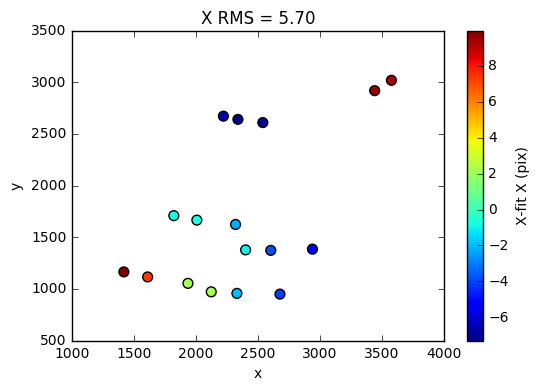

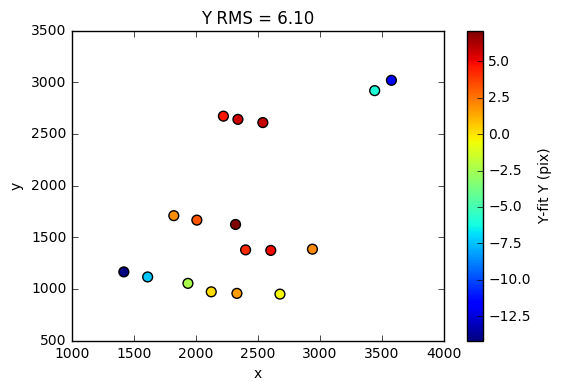

In [4]:
# let's see what the fit residuals look like
fitx, fity = fun.compute(fit_result.x)
plt.scatter(stars['x'], stars['y'], c=stars['x']-fitx, s=50)
cb = plt.colorbar()
cb.set_label('X-fit X (pix)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('X RMS = %.2f' % (stars['x']-fitx).std())

plt.figure()
plt.scatter(stars['x'], stars['y'], c=stars['y']-fity, s=50)
cb = plt.colorbar()
cb.set_label('Y-fit Y (pix)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Y RMS = %.2f' % (stars['y']-fity).std())

In [5]:
# Use the simple fit to make a good initial guess for a more complicated model
a_order = 2
b_order = 2
x0_new = np.zeros((a_order+1)**2+(b_order+1)**2 + 8)
# Use the affine transform that was found above
x0_new[-8:-2] = fit_result.x

fun = AZP_SIP(stars['x'], stars['y'], stars['alt'], stars['az'],
              ap_order=a_order, bp_order=b_order)
fit_result = minimize(fun, x0_new)
fitx, fity = fun.altaz2xy(fit_result.x)
print fit_result.x

[  4.04931881e+00   2.85852875e-01   3.57958730e-04  -3.57157380e-01
   9.05916391e-04   0.00000000e+00  -2.27727219e-04   0.00000000e+00
   0.00000000e+00  -2.14053019e+01   5.88258852e-01   1.83699006e-03
   1.30770039e+00   1.70063955e-03   0.00000000e+00  -9.22417807e-04
   0.00000000e+00   0.00000000e+00   3.32658014e+03   2.75600248e+03
  -6.41156816e+01   1.02972865e+01  -5.84978857e+01   2.73378456e+01
   2.57224455e+00  -1.45413895e+01]


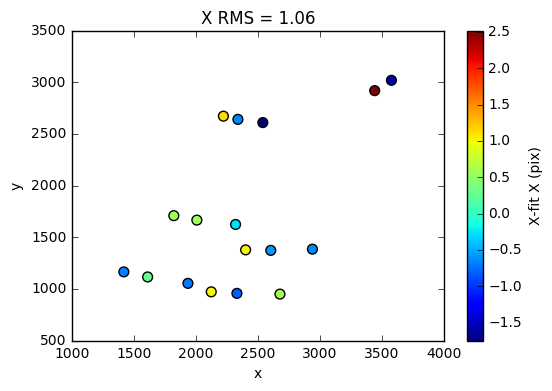

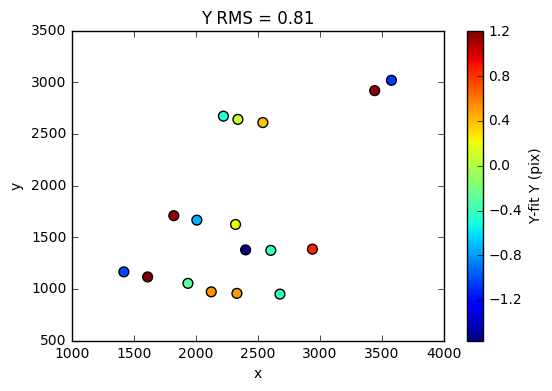

In [6]:
# let's see what the fit residuals look like
plt.scatter(stars['x'], stars['y'], c=stars['x']-fitx, s=50)
cb = plt.colorbar()
cb.set_label('X-fit X (pix)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('X RMS = %.2f' % (stars['x']-fitx).std())

plt.figure()
plt.scatter(stars['x'], stars['y'], c=stars['y']-fity, s=50)
cb = plt.colorbar()
cb.set_label('Y-fit Y (pix)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Y RMS = %.2f' % (stars['y']-fity).std())

In [7]:
# RMS is down to ~1 pixel in each direction, which is probably the floor since those were measured manually!